# Exploratory analysis of combined dataset

In [112]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [3]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [261]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final.pkl')

# drop CET datetime column; no longer needed
df.drop(columns=['datetime_cet'], inplace=True)
# move label/target to the end of the dataframe
rearranged_columns = [col for col in df.columns if col != 'actual_generated_smard_mwh'] + ['actual_generated_smard_mwh']
df = df[rearranged_columns]
# split SMARD forecasted feature since I don't want to use this in model training; then drop from df
smard_forecasted_generation_series = df['forecasted_generation_smard_mwh']
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48168 entries, 2018-01-01 00:00:00+00:00 to 2023-06-30 23:00:00+00:00
Data columns (total 32 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   hour                                            48168 non-null  int32  
 1   day_of_week                                     48168 non-null  int32  
 2   day_of_month                                    48168 non-null  int32  
 3   month_number                                    48168 non-null  int32  
 4   year                                            48168 non-null  int32  
 5   meteorological_season                           48168 non-null  object 
 6   turbines_in_operation                           48168 non-null  int64  
 7   total_nominal_capacity_operational_turbines_mw  48168 non-null  float64
 8   day_ahead_price_eur_mwh                         41618 non-null  float

In [255]:
# Separate these ERA5 and ERA5-derived param groups for quicker selections later
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_wind_gusts_10m',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m'
]

unweighted_wx_features = [
    'temp_2m_celsius',
    'wind_gusts_10m',
    'mean_sea_level_pressure_mb',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes as well
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

In [256]:
df.isna().sum()

hour                                                 0
day_of_week                                          0
day_of_month                                         0
month_number                                         0
year                                                 0
meteorological_season                                0
turbines_in_operation                                0
total_nominal_capacity_operational_turbines_mw       0
day_ahead_price_eur_mwh                           6550
total_nominal_capacity_smard_mw                      0
forecasted_generation_smard_mwh                     24
total_net_load_smard_mwh                             0
residual_load_smard_mwh                              0
mean_wind_speed_10m                                  0
mean_wind_speed_100m                                 0
wind_direction_angle_10m                             0
wind_direction_angle_100m                            0
mean_sea_level_pressure_mb                           0
wind_gusts

-----

### Just had an idea: Add German public holiday data to dataset!

#### Fetch German public holiday dates from free API service (thanks, guys! 👍🏻)
- Link: https://feiertage-api.de
- 117 public holidays during my chosen time period

In [7]:
# years = [2018, 2019, 2020, 2021, 2022, 2023]
# list_of_datadicts = []

# for year in years:
#     url_endpoint = f'https://feiertage-api.de/api/?jahr={year}&nur_daten'
#     response = requests.get(url_endpoint)

#     if response.status_code == 200:  
#             # Decode JSON response object to Python dict
#             list_of_datadicts.append(response.json())
#     else:
#         print(f'Request failed with status code: {response.status_code}')
        
# len(list_of_datadicts)

6

In [29]:
# df_public_holidays = pd.DataFrame(list_of_datadicts)

# # Map all dates to datetime timestamps localise to UTC (since only day alignment is needed, not hourly)
# df_public_holidays = df_public_holidays.map(lambda date: pd.to_datetime(date, yearfirst=True, utc=True))

# # Flatten the dataframe to 1D array of Timestamps!
# public_holiday_timestamps = df_public_holidays.to_numpy().flatten()

# # Creat new column by putting bool array as condition inside np.where and replacing bool with 0s & 1s
# df['public_holiday'] = np.where(df.index.isin(public_holiday_timestamps), 1, 0)

In [37]:
# df['public_holiday'].sum()

117

#### Save to pickle

In [38]:
# df.to_pickle(data_push_path / 'df_main_smard_era5_final.pkl')

-----

In [62]:
df

,hour,day_of_week,day_of_month,month_number,year,meteorological_season,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,actual_generated_smard_mwh,day_ahead_price_eur_mwh,total_nominal_capacity_smard_mw,forecasted_generation_smard_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,mean_sea_level_pressure_mb,wind_gusts_10m,temp_2m_celsius,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,weighted_temp_2m_celsius,weighted_wind_gusts_10m,weighted_mean_sea_level_pressure_mb,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m,public_holiday
datetime_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0,0,1,1,2018,winter,27464,49732.097897,29638.00,NaN,51633.0,29632.75,44270.00,11634.25,5.978772,10.395984,220.756622,225.207733,1000.349453,12.419700,8.510492,SW,SW,9.207286,13.089894,997.749018,6.337690,10.819870,223.051711,226.127482,SW,SW,1
2018-01-01 01:00:00+00:00,1,0,1,1,2018,winter,27464,49732.097897,30173.75,NaN,51633.0,30978.75,43195.75,9928.75,6.309438,10.805341,224.697327,228.564713,1000.427969,13.007113,8.281854,SW,SW,8.921161,13.771541,997.737445,6.722992,11.314126,226.120270,228.464003,SW,SW,0
2018-01-01 02:00:00+00:00,2,0,1,1,2018,winter,27464,49732.097897,31021.50,NaN,51633.0,32154.25,42527.50,8371.50,6.685641,11.288467,228.800705,232.298874,1000.821328,13.622252,8.135431,SW,SW,8.717961,14.434282,998.046871,7.154381,11.899254,229.267554,231.341858,SW,SW,0
2018-01-01 03:00:00+00:00,3,0,1,1,2018,winter,27464,49732.097897,31015.00,NaN,51633.0,33045.50,42515.75,8291.25,6.894922,11.552816,231.736252,235.041382,1001.264219,14.090265,7.977838,SW,SW,8.495501,14.913757,998.378348,7.391741,12.219056,230.808404,232.740422,SW,SW,0
2018-01-01 04:00:00+00:00,4,0,1,1,2018,winter,27464,49732.097897,31534.00,NaN,51633.0,33644.50,42278.00,7465.50,7.060956,11.751130,234.274536,236.804169,1001.436406,14.186666,7.647913,SW,WSW,8.080761,14.866367,998.388523,7.513337,12.358206,231.433313,233.460190,SW,SW,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 19:00:00+00:00,19,4,30,6,2023,summer,29412,59315.041337,1698.75,130.74,57590.0,2271.50,48794.25,44133.75,1.842328,3.449438,277.569061,278.582458,1010.896875,3.549851,17.934381,W,W,18.057953,3.268352,1010.494333,1.735454,3.298011,267.207132,272.506988,W,W,0
2023-06-30 20:00:00+00:00,20,4,30,6,2023,summer,29412,59315.041337,2334.25,122.39,57590.0,2382.75,46764.00,41337.00,1.792745,3.391158,265.232117,275.095490,1011.285156,3.295196,16.834222,W,W,16.788159,3.169172,1010.739602,1.802858,3.440641,246.381887,261.133282,WSW,W,0
2023-06-30 21:00:00+00:00,21,4,30,6,2023,summer,29412,59315.041337,3734.00,109.47,57590.0,2862.75,43702.00,36306.00,1.922537,3.609585,253.096542,263.328888,1011.060078,3.497805,16.122461,WSW,W,16.075749,3.555140,1010.446129,2.041097,3.894662,235.312803,244.281213,SW,WSW,0


In [63]:
df.describe()

,hour,day_of_week,day_of_month,month_number,year,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,actual_generated_smard_mwh,day_ahead_price_eur_mwh,total_nominal_capacity_smard_mw,forecasted_generation_smard_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,mean_sea_level_pressure_mb,wind_gusts_10m,temp_2m_celsius,weighted_temp_2m_celsius,weighted_wind_gusts_10m,weighted_mean_sea_level_pressure_mb,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,public_holiday
count,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,41618.000000,48168.000000,48144.00000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000
mean,11.500000,2.997509,15.716492,6.251619,2020.270553,28625.879422,54216.183891,11193.426461,97.951645,53849.704638,11099.65571,56219.703579,36924.776340,3.403946,5.747104,191.878098,194.632889,1016.364811,6.945310,10.216761,10.357187,7.247443,1015.912618,3.642511,6.125059,195.617986,198.109288,0.002429
std,6.922258,1.999396,8.793736,3.439449,1.599109,462.136710,2355.850195,8992.759097,107.700848,1700.822139,8848.40467,9832.762332,12559.928192,1.373546,2.210253,64.455742,65.061592,9.026248,2.917239,7.485719,7.343503,3.079814,9.431296,1.496988,2.373912,67.100808,67.589109,0.049225
min,0.000000,0.000000,1.000000,1.000000,2018.000000,27464.000000,49732.097897,100.250000,-129.960000,51633.000000,161.25000,30909.000000,-5370.500000,0.819818,1.150553,22.478209,21.372946,972.342813,1.910964,-12.340430,-12.353219,1.816411,971.750173,0.860357,1.186652,18.788045,19.789689,0.000000
25%,5.750000,1.000000,8.000000,3.000000,2019.000000,28304.000000,52353.193417,4245.875000,35.050000,52792.000000,4313.50000,48175.687500,28525.562500,2.391495,4.161518,146.448418,148.723846,1011.134180,4.782694,4.303812,4.642113,4.962623,1010.345478,2.527088,4.397004,147.137573,148.870189,0.000000
50%,11.500000,3.000000,16.000000,6.000000,2020.000000,28664.000000,53790.932467,8473.000000,53.920000,53184.000000,8413.62500,56035.250000,37295.125000,3.090817,5.346018,200.376053,204.613251,1016.906797,6.369528,9.597971,9.776790,6.645048,1016.555933,3.320524,5.722192,207.578807,211.532572,0.000000
75%,17.250000,5.000000,23.000000,9.000000,2022.000000,28982.000000,56033.684347,15918.500000,119.802500,55289.000000,15543.68750,64212.000000,45628.437500,4.094744,6.930403,242.063076,245.364609,1022.105957,8.502666,15.746774,15.714599,8.909549,1022.037480,4.424359,7.448320,247.089817,249.770198,0.000000
max,23.000000,6.000000,31.000000,12.000000,2023.000000,29418.000000,59315.041337,45285.250000,871.000000,57590.000000,43017.75000,81077.500000,74313.250000,11.017428,17.585875,335.886993,338.821259,1041.468125,23.699093,33.672296,33.866775,25.159453,1041.719498,12.178314,19.184025,339.868895,341.861569,1.000000


In [221]:
def plot_correlation_heatmap(df):
    # Get the correlation matrix as a dataframe
    corr = df.corr(numeric_only=True)

    # Create mask to remove redundant half
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Abbreviate column names; select only numeric columns in df!
    abbreviated_column_names = [col[:30] + '...' if len(col) > 25 else col for col in df.select_dtypes('number').columns]
    
    # A couple of divergent colour palettes to see what works best
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={'shrink': .2}, annot=True, fmt='.1f', annot_kws={'size': 6},
                xticklabels=abbreviated_column_names, yticklabels=abbreviated_column_names)
    
    # Rotate x labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=6)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)

    # plt.tight_layout()
    plt.show()

In [248]:
df.loc[:, ~df.columns.isin(weighted_wx_features)]

,hour,day_of_week,day_of_month,month_number,year,meteorological_season,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,day_ahead_price_eur_mwh,total_nominal_capacity_smard_mw,forecasted_generation_smard_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,mean_sea_level_pressure_mb,wind_gusts_10m,temp_2m_celsius,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,public_holiday,actual_generated_smard_mwh
datetime_utc,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0,0,1,1,2018,winter,27464,49732.097897,NaN,51633.0,29632.75,44270.00,11634.25,5.978772,10.395984,220.756622,225.207733,1000.349453,12.419700,8.510492,SW,SW,1,29638.00
2018-01-01 01:00:00+00:00,1,0,1,1,2018,winter,27464,49732.097897,NaN,51633.0,30978.75,43195.75,9928.75,6.309438,10.805341,224.697327,228.564713,1000.427969,13.007113,8.281854,SW,SW,0,30173.75
2018-01-01 02:00:00+00:00,2,0,1,1,2018,winter,27464,49732.097897,NaN,51633.0,32154.25,42527.50,8371.50,6.685641,11.288467,228.800705,232.298874,1000.821328,13.622252,8.135431,SW,SW,0,31021.50
2018-01-01 03:00:00+00:00,3,0,1,1,2018,winter,27464,49732.097897,NaN,51633.0,33045.50,42515.75,8291.25,6.894922,11.552816,231.736252,235.041382,1001.264219,14.090265,7.977838,SW,SW,0,31015.00
2018-01-01 04:00:00+00:00,4,0,1,1,2018,winter,27464,49732.097897,NaN,51633.0,33644.50,42278.00,7465.50,7.060956,11.751130,234.274536,236.804169,1001.436406,14.186666,7.647913,SW,WSW,0,31534.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 19:00:00+00:00,19,4,30,6,2023,summer,29412,59315.041337,130.74,57590.0,2271.50,48794.25,44133.75,1.842328,3.449438,277.569061,278.582458,1010.896875,3.549851,17.934381,W,W,0,1698.75
2023-06-30 20:00:00+00:00,20,4,30,6,2023,summer,29412,59315.041337,122.39,57590.0,2382.75,46764.00,41337.00,1.792745,3.391158,265.232117,275.095490,1011.285156,3.295196,16.834222,W,W,0,2334.25
2023-06-30 21:00:00+00:00,21,4,30,6,2023,summer,29412,59315.041337,109.47,57590.0,2862.75,43702.00,36306.00,1.922537,3.609585,253.096542,263.328888,1011.060078,3.497805,16.122461,WSW,W,0,3734.00


In [241]:
df.loc[:, weighted_wx_features]

,weighted_temp_2m_celsius,weighted_wind_gusts_10m,weighted_mean_sea_level_pressure_mb,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m
datetime_utc,,,,,,,,,
2018-01-01 00:00:00+00:00,9.207286,13.089894,997.749018,6.337690,10.819870,223.051711,226.127482,SW,SW
2018-01-01 01:00:00+00:00,8.921161,13.771541,997.737445,6.722992,11.314126,226.120270,228.464003,SW,SW
2018-01-01 02:00:00+00:00,8.717961,14.434282,998.046871,7.154381,11.899254,229.267554,231.341858,SW,SW
2018-01-01 03:00:00+00:00,8.495501,14.913757,998.378348,7.391741,12.219056,230.808404,232.740422,SW,SW
2018-01-01 04:00:00+00:00,8.080761,14.866367,998.388523,7.513337,12.358206,231.433313,233.460190,SW,SW
...,...,...,...,...,...,...,...,...,...
2023-06-30 19:00:00+00:00,18.057953,3.268352,1010.494333,1.735454,3.298011,267.207132,272.506988,W,W
2023-06-30 20:00:00+00:00,16.788159,3.169172,1010.739602,1.802858,3.440641,246.381887,261.133282,WSW,W
2023-06-30 21:00:00+00:00,16.075749,3.555140,1010.446129,2.041097,3.894662,235.312803,244.281213,SW,WSW


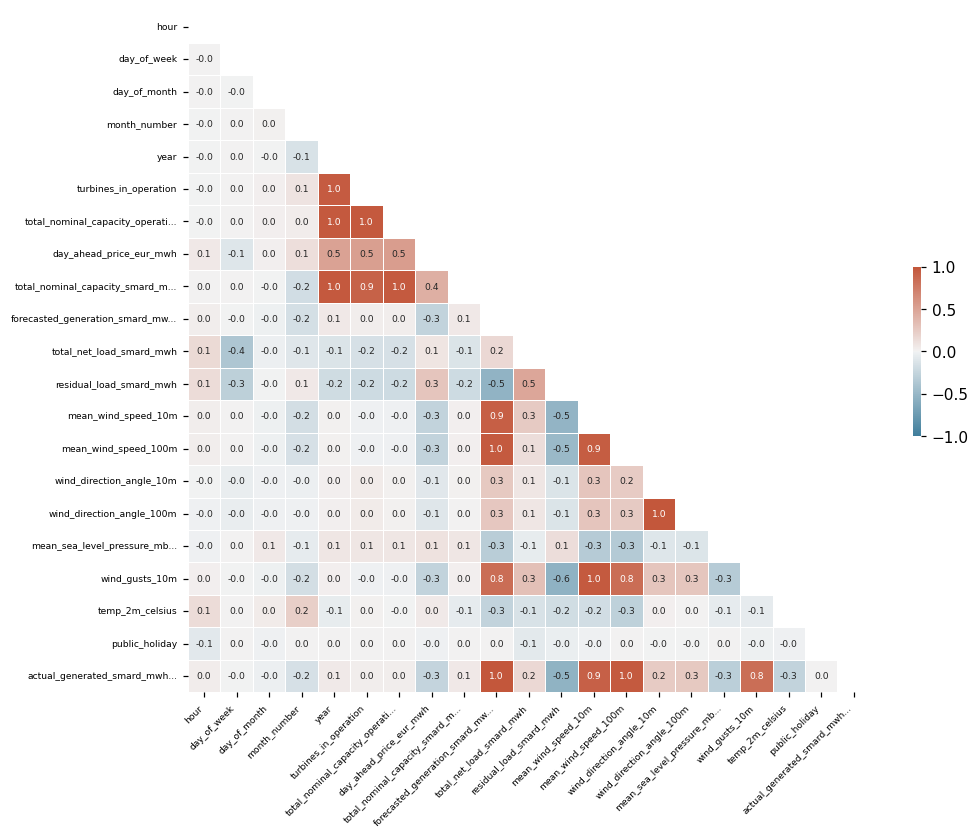

In [257]:
plot_correlation_heatmap(df_unweighted)

In [64]:
df.corr(numeric_only=True)

,hour,day_of_week,day_of_month,month_number,year,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,actual_generated_smard_mwh,day_ahead_price_eur_mwh,total_nominal_capacity_smard_mw,forecasted_generation_smard_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,mean_sea_level_pressure_mb,wind_gusts_10m,temp_2m_celsius,weighted_temp_2m_celsius,weighted_wind_gusts_10m,weighted_mean_sea_level_pressure_mb,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,public_holiday
hour,1.000000e+00,-1.249969e-17,-2.261487e-17,-1.848278e-16,-2.384484e-15,-1.984061e-15,-2.051047e-15,0.032045,0.055909,0.000121,0.026921,0.149247,0.136032,0.028433,0.024828,-0.001581,-0.007951,-0.009963,0.020658,0.134052,0.131451,0.019937,-0.005600,0.024456,0.019861,-0.001364,-0.005998,-0.081978
day_of_week,-1.249969e-17,1.000000e+00,-1.315441e-03,1.870063e-05,1.301713e-03,2.907325e-03,1.914588e-03,-0.002135,-0.102792,0.000921,-0.005379,-0.376687,-0.294900,0.000516,0.000278,-0.040148,-0.040944,0.003323,-0.000235,0.000657,-0.002556,0.001163,0.006372,0.001224,0.000018,-0.040999,-0.041738,0.001538
day_of_month,-2.261487e-17,-1.315441e-03,1.000000e+00,1.118868e-02,-2.198818e-03,2.132324e-02,1.821742e-02,-0.023753,0.016865,-0.003177,-0.021245,-0.023449,-0.006014,-0.022170,-0.020291,-0.009599,-0.009980,0.059916,-0.021253,0.039320,0.042575,-0.023615,0.059070,-0.024245,-0.022240,-0.002150,-0.003213,-0.014284
month_number,-1.848278e-16,1.870063e-05,1.118868e-02,1.000000e+00,-1.349501e-01,8.639575e-02,3.887332e-02,-0.155078,0.120355,-0.173999,-0.156462,-0.097039,0.055444,-0.165043,-0.151150,-0.024038,-0.012909,-0.060259,-0.169176,0.222328,0.228314,-0.149963,-0.058670,-0.143940,-0.130530,-0.025650,-0.015014,0.000927
year,-2.384484e-15,1.301713e-03,-2.198818e-03,-1.349501e-01,1.000000e+00,9.569315e-01,9.746318e-01,0.053579,0.503324,0.975036,0.056063,-0.120341,-0.193584,0.014224,0.012909,0.022271,0.018041,0.073827,0.015639,-0.051162,-0.052050,0.009140,0.066823,0.004967,0.002787,0.023013,0.017307,0.001146
turbines_in_operation,-1.984061e-15,2.907325e-03,2.132324e-02,8.639575e-02,9.569315e-01,1.000000e+00,9.760246e-01,0.028470,0.527411,0.920603,0.029835,-0.150414,-0.197695,-0.013996,-0.012606,0.042303,0.040166,0.073981,-0.013755,0.009885,0.011758,-0.014959,0.064940,-0.017797,-0.017356,0.044185,0.040476,0.001207
total_nominal_capacity_operational_turbines_mw,-2.051047e-15,1.914588e-03,1.821742e-02,3.887332e-02,9.746318e-01,9.760246e-01,1.000000e+00,0.028552,0.537676,0.963705,0.030713,-0.151709,-0.198926,-0.012516,-0.012208,0.012370,0.009996,0.072424,-0.010938,-0.000905,-0.001012,-0.014947,0.066549,-0.018858,-0.019453,0.014092,0.010207,0.001496
actual_generated_smard_mwh,3.204525e-02,-2.135102e-03,-2.375272e-02,-1.550779e-01,5.357948e-02,2.847024e-02,2.855162e-02,1.000000,-0.254283,0.058892,0.986371,0.159478,-0.543971,0.926360,0.962236,0.248964,0.259098,-0.301058,0.841823,-0.260327,-0.252982,0.861817,-0.357803,0.934209,0.969680,0.205934,0.213679,0.003325
day_ahead_price_eur_mwh,5.590925e-02,-1.027916e-01,1.686476e-02,1.203546e-01,5.033236e-01,5.274109e-01,5.376757e-01,-0.254283,1.000000,0.427446,-0.262279,0.080288,0.288101,-0.264074,-0.259184,-0.092406,-0.095425,0.097191,-0.261688,0.049040,0.045460,-0.272362,0.111578,-0.273110,-0.268178,-0.082275,-0.084407,-0.014688
total_nominal_capacity_smard_mw,1.208006e-04,9.205728e-04,-3.176670e-03,-1.739991e-01,9.750360e-01,9.206025e-01,9.637054e-01,0.058892,0.427446,1.000000,0.061791,-0.123230,-0.196355,0.020696,0.018613,0.008930,0.004516,0.071017,0.022548,-0.060372,-0.061703,0.013656,0.065901,0.009161,0.006351,0.009340,0.003548,0.001488


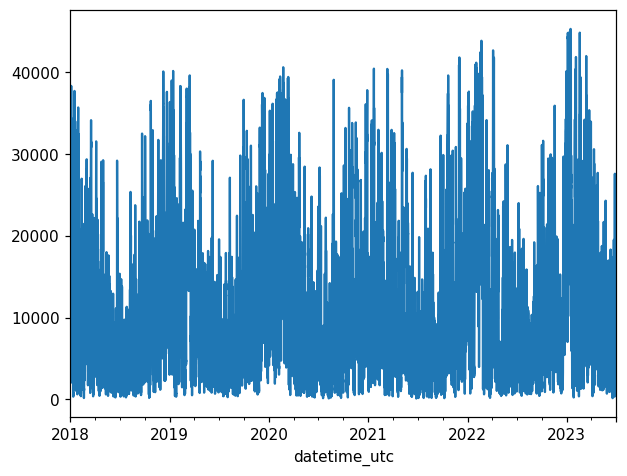

In [69]:
df['actual_generated_smard_mwh'].plot();

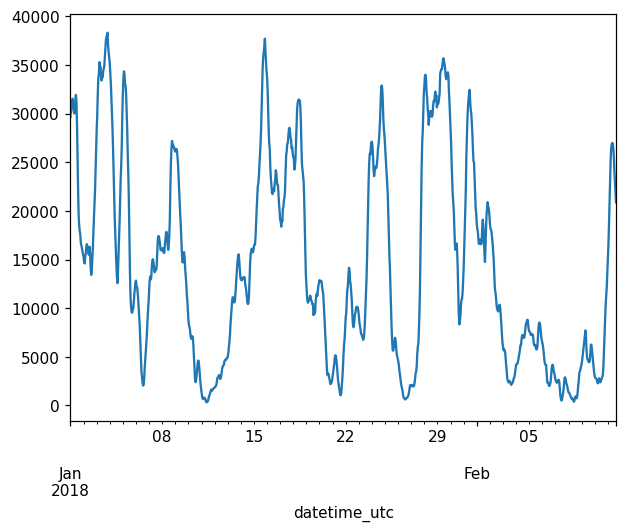

In [68]:
df['actual_generated_smard_mwh'].iloc[0:1_000].plot();

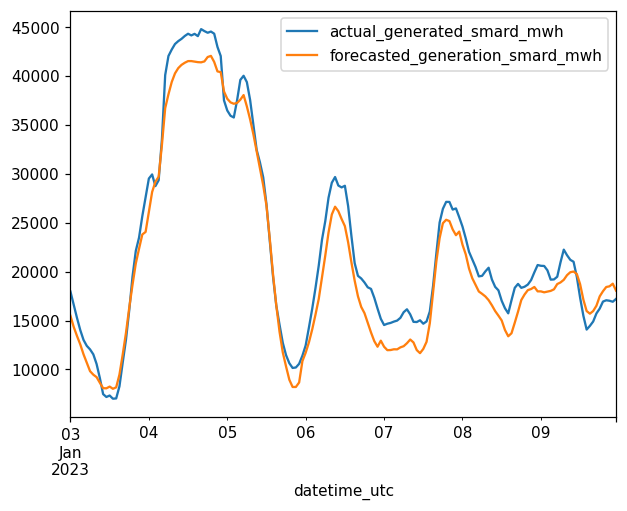

In [113]:
# SMARD actual vs SMARD forecasted
df.loc['2023-01-03': '2023-01-09'].plot(kind='line', y=['actual_generated_smard_mwh', 'forecasted_generation_smard_mwh']);

In [81]:
# filter on just one day
# df.loc['2023-01-01']

### Plot a seasonal decomposition plot
- Use statsmodels' `seasonal_decompose`
    - https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

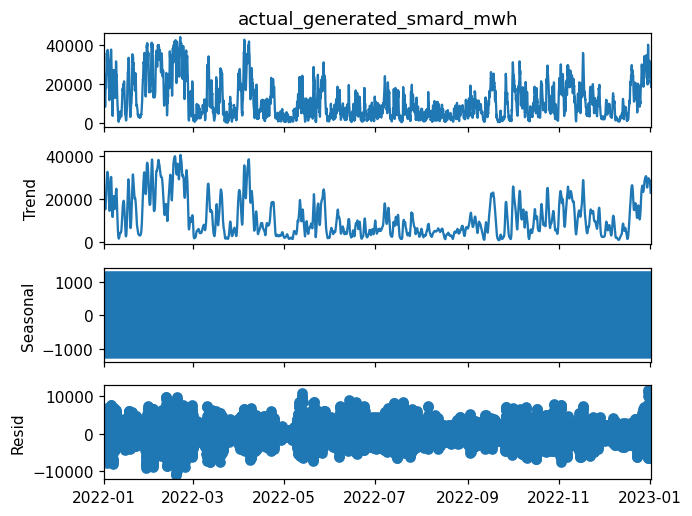

In [110]:
decomposed_result = seasonal_decompose(df.loc['2022-01-01':'2023-01-01', 'actual_generated_smard_mwh'], model='additive')
decomposed_result.plot()
plt.show()